In [89]:
%matplotlib widget
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import polars as pl
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
plt.ion()

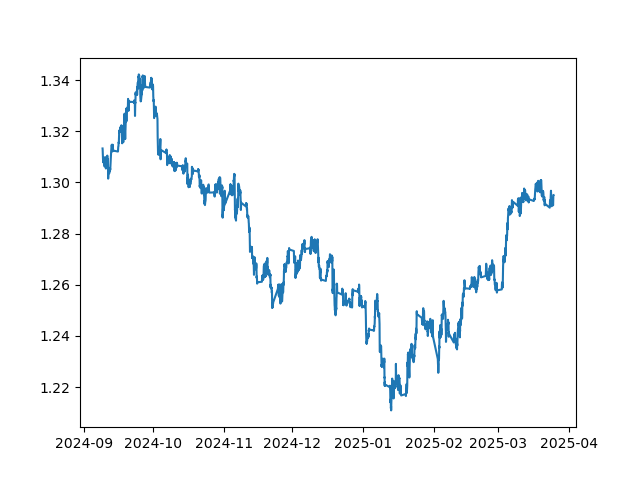

(3356, 1) (3356, 1)


In [148]:
fileName = "GBPUSD_M1.csv"
data = pd.read_csv(fileName)

priceData = pl.DataFrame(data[["Time", "Close"]]).select([
    pl.col("Time").str.strptime(pl.Datetime, "%Y-%m-%d %H:%M"),
    pl.col("Close")
])

priceData = (
    priceData.sort(by="Time")
    .group_by_dynamic("Time", every="1h")
    .agg(pl.col("Close").median())
    .drop_nulls()
)

timeSeries = priceData.select(pl.col("Time").dt.timestamp()).to_numpy()
priceSeries = priceData.select(pl.col("Close")).to_numpy()

fig = plt.figure(fileName)
plt.clf()
plt.plot([datetime.fromtimestamp(timestamp/1e6) for timestamp in timeSeries[:,0]],priceSeries)
plt.title("")
plt.show()

print(timeSeries.shape, priceSeries.shape)

In [145]:
def gprPredict(start, window):
    X = timeSeries[-start-window:-start,0]
    y = priceSeries[-start-window:-start,0]

    output = np.array([[timeSeries[-start,0], priceSeries[-start,0], .0005]])
    return output

In [ ]:

def plotGPR(timeSeries, meanSeries, stdSeries):
    plt.clf()
    plt.scatter([datetime.fromtimestamp(timestamp/1e6) for timestamp in timeSeries], meanSeries)
    plt.fill_between(
        [datetime.fromtimestamp(timestamp/1e6) for timestamp in timeSeries],
        meanSeries - 1.96 * stdSeries,
        meanSeries + 1.96 * stdSeries,
        alpha=0.5,
        color='darkorange'
    )
    date_format = mdates.DateFormatter('%b %d')
    plt.gcf().axes[0].xaxis.set_major_formatter(date_format)
    plt.show()

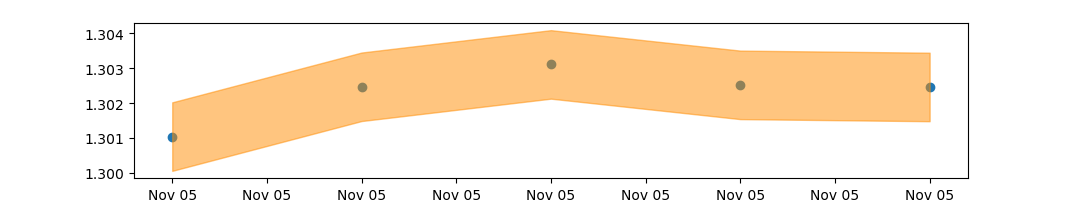

In [147]:
fig = plt.figure(2)
predictSeries = gprPredict(-1000, 100)
for i in range(1, 5):
    predictSeries = np.vstack((predictSeries, gprPredict(-1000+i, 100)))

plotGPR(predictSeries[:,0], predictSeries[:,1], predictSeries[:,2])
